<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/SVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[0] Loss: 600.0000, Radius: 0.0000
[20] Loss: 600.0000, Radius: 0.0000
[40] Loss: 600.0000, Radius: 0.0000
[60] Loss: 600.0000, Radius: 0.0000
[80] Loss: 600.0000, Radius: 0.0000
[100] Loss: 600.0000, Radius: 0.0000
[120] Loss: 600.0000, Radius: 0.0000
[140] Loss: 600.0000, Radius: 0.0000
[160] Loss: 600.0000, Radius: 0.0000
[180] Loss: 600.0000, Radius: 0.0000
[200] Loss: 600.0000, Radius: 0.0000
[220] Loss: 600.0000, Radius: 0.0000
[240] Loss: 600.0000, Radius: 0.0000
[260] Loss: 600.0000, Radius: 0.0000
[280] Loss: 600.0000, Radius: 0.0000
[300] Loss: 600.0000, Radius: 0.0000
[320] Loss: 600.0000, Radius: 0.0000
[340] Loss: 600.0000, Radius: 0.0000
[360] Loss: 600.0000, Radius: 0.0000
[380] Loss: 600.0000, Radius: 0.0000
[400] Loss: 600.0000, Radius: 0.0000
[420] Loss: 600.0000, Radius: 0.0000
[440] Loss: 600.0000, Radius: 0.0000
[460] Loss: 600.0000, Radius: 0.0000
[480] Loss: 600.0000, Radius: 0.0000
[500] Loss: 600.0000, Radius: 0.0000
[520] Loss: 600.0000, Radius: 0.0000
[540] L

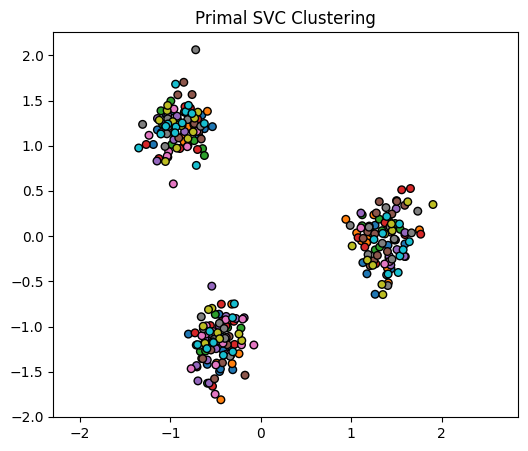

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import numpy as np
import networkx as nx

# ----- Model Definitions -----

class PhiNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, feature_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            #nn.Linear(hidden_dim, feature_dim)
        )

    def forward(self, x):
        return x#self.model(x)

class DeepPrimalSVC(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.C = C
        self.radius = nn.Parameter(torch.tensor(0.0))
        self.b_logits = None

    def forward(self, x, phi_model):
        phi_x = phi_model(x)
        if self.b_logits is None or self.b_logits.shape[0] != x.shape[0]:
            self.b_logits = nn.Parameter(torch.zeros(x.shape[0], device=x.device))

        beta = F.softmax(self.b_logits, dim=0)
        a = torch.sum(beta[:, None] * phi_x, dim=0)
        dists = torch.sum((phi_x - a)**2, dim=1)
        hinge = F.relu(dists - self.radius**2)
        loss = self.radius**2 + self.C * torch.sum(hinge)
        return loss, dists.detach(), self.radius.detach(), a.detach(), beta.detach(), phi_x.detach()

# ----- Dataset Options -----
dataset_loaders = {
    "moons": lambda: datasets.make_moons(n_samples=300, noise=0.1),
    "blobs": lambda: datasets.make_blobs(n_samples=300, centers=3, cluster_std=1.0),
    "circles": lambda: datasets.make_circles(n_samples=300, factor=0.5, noise=0.05),
    "varied": lambda: datasets.make_blobs(n_samples=300, centers=[[0,0],[3,3],[0,4]], cluster_std=[0.3,0.7,0.5])
}

# Choose dataset
X_np, _ = dataset_loaders["blobs"]()
X_np = StandardScaler().fit_transform(X_np)
X = torch.tensor(X_np, dtype=torch.float32)

# ----- Train Model -----
phi = PhiNet(2, 2, 16)
svc = DeepPrimalSVC(C=1.0)
opt = torch.optim.Adam(list(phi.parameters()) + list(svc.parameters()), lr=1e-2)

for epoch in range(2000):
    opt.zero_grad()
    loss, dists, R, a, beta, phi_x = svc(X, phi)
    loss.backward()
    opt.step()
    if epoch % 20 == 0:
        print(f"[{epoch}] Loss: {loss.item():.4f}, Radius: {R.item():.4f}")

# ----- Build Connectivity Graph -----
def inside_sphere(y):
    return (y - a).pow(2).sum() <= R**2

N = X.shape[0]
adj = np.zeros((N, N))
with torch.no_grad():
    phi_X = phi(X)  # Precompute all phi(x_i) to save time

    for i in range(N):
        for j in range(i + 1, N):
            if dists[i] > R**2 or dists[j] > R**2:
                continue

            # Interpolate in feature space
            samples = torch.linspace(0, 1, steps=20).view(-1, 1).to(X.device)  # [20, 1]
            phi_path = (1 - samples) * phi_X[i] + samples * phi_X[j]  # [20, D]

            # Compute distance from center a for each interpolated point
            path_d = torch.sum((phi_path - a)**2, dim=1)  # [20]

            if torch.all(path_d <= R**2):
                adj[i, j] = adj[j, i] = 1


# ----- Extract Clusters -----
G = nx.from_numpy_array(adj)
components = list(nx.connected_components(G))
cluster_labels = np.full(N, -1)
for label, comp in enumerate(components):
    for idx in comp:
        cluster_labels[idx] = label

# ----- Visualization -----
plt.figure(figsize=(6, 5))
plt.scatter(X_np[:, 0], X_np[:, 1], c=cluster_labels, cmap='tab10', s=30, edgecolor='k')
plt.title("Primal SVC Clustering")
plt.axis('equal')
plt.show()


In [31]:
beta

tensor([0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 

Epoch 0, Loss: 2274.4753
Epoch 100, Loss: 122.0084
Epoch 200, Loss: 120.9205
Epoch 300, Loss: 120.9205
Epoch 400, Loss: 120.9208
Epoch 500, Loss: 120.9205
Epoch 600, Loss: 120.9190
Epoch 700, Loss: 120.9227
Epoch 800, Loss: 120.9215
Epoch 900, Loss: 120.9226
Epoch 1000, Loss: 120.9235
Epoch 1100, Loss: 120.9312
Epoch 1200, Loss: 120.9225
Epoch 1300, Loss: 120.9201
Epoch 1400, Loss: 120.9203
Epoch 1500, Loss: 120.9238
Epoch 1600, Loss: 120.9366
Epoch 1700, Loss: 120.9293
Epoch 1800, Loss: 120.9347
Epoch 1900, Loss: 120.9276
Epoch 2000, Loss: 120.9225
Epoch 2100, Loss: 120.9250
Epoch 2200, Loss: 120.9301
Epoch 2300, Loss: 120.9265
Epoch 2400, Loss: 120.9246
Epoch 2500, Loss: 120.9233
Epoch 2600, Loss: 120.9276
Epoch 2700, Loss: 120.9482
Epoch 2800, Loss: 120.9261
Epoch 2900, Loss: 120.9297
Detected 11 clusters.


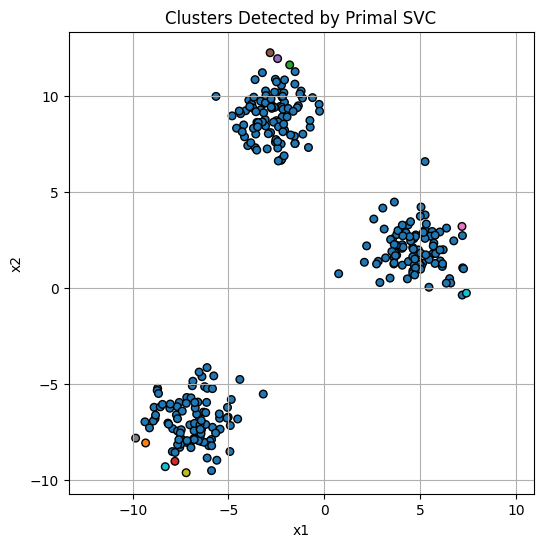

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components

# Step 1: Load blob data
X_np, _ = make_blobs(n_samples=300, centers=3, random_state=42, cluster_std=1.2)
X = torch.tensor(X_np, dtype=torch.float32)

# Step 2: Define a simple feature map (MLP)
class FeatureMap(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8, output_dim=4):
        super().__init__()
        self.out_features = output_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)
class FeatureMap(nn.Module):
    def __init__(self, input_dim=2):
        super().__init__()
        self.out_features = input_dim  # for consistency

    def forward(self, x):
        return x

# Step 3: Primal SVC model
class PrimalSVC(nn.Module):
    def __init__(self, feature_map, C=0.1):
        super().__init__()
        self.phi = feature_map
        self.center = nn.Parameter(torch.randn(feature_map.out_features))
        self.radius = nn.Parameter(torch.tensor(1.0))
        self.C = C

    def forward(self, x):
        phi_x = self.phi(x)
        dist_sq = torch.sum((phi_x - self.center) ** 2, dim=1)
        slack = torch.clamp(dist_sq - self.radius**2, min=0)
        loss = self.radius**2 + self.C * torch.sum(slack)
        return loss, dist_sq, slack

# Step 4: Train the model
model = PrimalSVC(FeatureMap())
optimizer = optim.Adam(model.parameters(), lr=1e-2)

for epoch in range(3000):
    optimizer.zero_grad()
    loss, dist_sq, slack = model(X)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Step 5: Cluster assignment via path-checking
@torch.no_grad()
def build_adjacency(X, model, num_samples=20):
    N = X.shape[0]
    A = np.zeros((N, N), dtype=int)
    phi = model.phi
    c = model.center
    R2 = model.radius.item() ** 2

    phi_X = phi(X)
    for i in range(N):
        for j in range(i + 1, N):
            samples = torch.linspace(0, 1, num_samples).view(-1, 1)
            interp = X[i] * (1 - samples) + X[j] * samples
            phi_interp = phi(interp)
            dist_sq = torch.sum((phi_interp - c) ** 2, dim=1)
            if torch.all(dist_sq <= R2):
                A[i, j] = A[j, i] = 1
    return A

A = build_adjacency(X, model, num_samples=20)
n_clusters, labels = connected_components(A, directed=False)

print(f"Detected {n_clusters} clusters.")

# Step 6: Plot the clustered data
plt.figure(figsize=(6, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], c=labels, cmap='tab10', s=30, edgecolors='k')
plt.title("Clusters Detected by Primal SVC")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.axis("equal")
plt.show()


In [39]:
~model.radius

Parameter containing:
tensor(10.2779, requires_grad=True)

Iter 0, Obj: 1.000000, Grad Norm: 10.000000
Iter 100, Obj: -303332.875000, Grad Norm: 13057.557617
Iter 200, Obj: -303332.875000, Grad Norm: 13057.557617
Iter 300, Obj: -303332.875000, Grad Norm: 13057.557617
Iter 400, Obj: -303332.875000, Grad Norm: 13057.557617
Iter 500, Obj: -303332.875000, Grad Norm: 13057.557617
Iter 600, Obj: -303332.875000, Grad Norm: 13057.557617
Iter 700, Obj: -303332.875000, Grad Norm: 13057.557617
Iter 800, Obj: -303332.875000, Grad Norm: 13057.557617
Iter 900, Obj: -303332.875000, Grad Norm: 13057.557617
No proper support vectors found in (0, C). Using fallback: max over all non-zero β.
Estimated radius R^2: 302820.1219
Identified clusters: 34


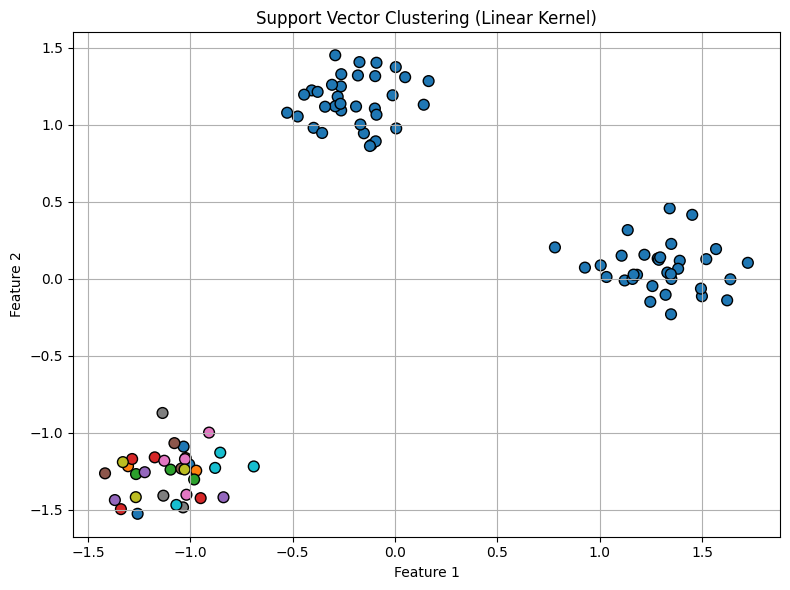

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse.csgraph import connected_components
import torch

class TorchQPOptimizer:
    def __init__(self, K, C=0.1, device='cpu'):
        self.km = torch.as_tensor(K, dtype=torch.float32, device=device)
        self.N = self.km.shape[0]
        self.C = C
        self.device = device
        self.beta = None

    def _objective(self, beta):
        return torch.sum(beta) - beta @ self.km @ beta

    def _project_box(self, beta):
        return beta.clamp(0.0, self.C)

    def _project_sum_constraint(self, beta):
        return beta + (1 - beta.sum()) / self.N

    def _project(self, beta):
        beta = self._project_box(beta)
        beta = self._project_sum_constraint(beta)
        return beta

    def find_beta(self, max_iter=1000, lr=0.1, tol=1e-6, verbose=False):
        beta = torch.full((self.N,), 1.0 / self.N, device=self.device, requires_grad=True)

        for i in range(max_iter):
            obj = self._objective(beta)
            obj.backward()
            grad = beta.grad

            with torch.no_grad():
                beta += lr * grad
                beta = self._project(beta)

            beta.requires_grad_(True)
            beta.grad = None

            if verbose and i % 100 == 0:
                print(f"Iter {i}, Obj: {obj.item():.6f}, Grad Norm: {grad.norm().item():.6f}")

            if grad.norm() < tol:
                if verbose:
                    print(f"Converged at iteration {i}")
                break

        self.beta = beta.detach().cpu().numpy()
        return self.beta

def compute_r_squared(X, K, beta):
    K_diag = np.diag(K)
    return K_diag - 2 * (K @ beta) + beta @ K @ beta

def build_adjacency(X, R, beta, K, num_samples=20):
    N = len(X)
    A = np.zeros((N, N), dtype=bool)

    for i in range(N):
        for j in range(i + 1, N):
            line = np.linspace(0, 1, num_samples)[:, None] * X[i] + \
                   (1 - np.linspace(0, 1, num_samples)[:, None]) * X[j]
            K_line = linear_kernel(line, X)
            line_norm_sq = np.sum(line * line, axis=1)
            R_line_sq = line_norm_sq - 2 * K_line @ beta + beta @ K @ beta

            if np.all(R_line_sq <= R + 1e-6):
                A[i, j] = A[j, i] = True
    return A

def run_svc_clustering():
    # Step 1: Generate synthetic data
    X, _ = make_blobs(n_samples=100, centers=3, random_state=42)
    X = StandardScaler().fit_transform(X)

    # Step 2: Compute linear kernel
    K = linear_kernel(X, X)

    # Step 3: Solve for beta
    svc = TorchQPOptimizer(K, C=10.0)
    beta = svc.find_beta(verbose=True)

    # Step 4: Compute R^2(x) for all points
    R_sq = compute_r_squared(X, K, beta)

    # Step 5: Radius R is defined by support vectors (0 < β < C)
    sv_mask = (beta > 1e-5) & (beta < 0.1 - 1e-5)
    sv_mask = (beta > 1e-5) & (beta < 0.1 - 1e-5)

    if np.any(sv_mask):
        R = np.max(R_sq[sv_mask])
    else:
        print("No proper support vectors found in (0, C). Using fallback: max over all non-zero β.")
        fallback_mask = beta > 1e-5
        if np.any(fallback_mask):
            R = np.max(R_sq[fallback_mask])
        else:
            raise ValueError("No non-zero β found. Clustering failed.")


    print(f"Estimated radius R^2: {R:.4f}")

    # Step 6: Build adjacency graph
    A = build_adjacency(X, R, beta, K, num_samples=20)

    # Step 7: Connected components as clusters
    n_components, labels = connected_components(A)
    print(f"Identified clusters: {n_components}")

    # Step 8: Plot result
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=60, edgecolor='k')
    plt.title("Support Vector Clustering (Linear Kernel)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_svc_clustering()


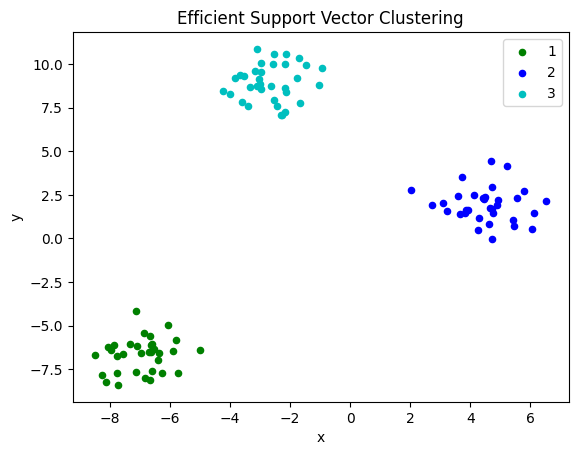

In [79]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import rbf_kernel
import networkx as nx
from pandas import DataFrame

# Generate dataset
X, _ = make_blobs(n_samples=100, centers=3, random_state=42)

# Parameters
N = len(X)
q = 0.5  # Kernel width
p = 0.1
C = 1 / (N * p)

# RBF Kernel matrix
K = rbf_kernel(X, gamma=q)

# Solve dual optimization
beta = cp.Variable(N)
objective = cp.Maximize(cp.sum(beta) - cp.quad_form(beta, K))
objective = cp.Maximize(cp.sum(beta) - cp.quad_form(beta, cp.psd_wrap(K)))

constraints = [beta >= 0, beta <= C, cp.sum(beta) == 1]
cp.Problem(objective, constraints).solve()


beta_val = beta.value
sv_mask = (beta_val > 1e-6) & (beta_val < C)
bsv_mask = beta_val >= C
SVs = np.where(sv_mask)[0]
BSVs = np.where(bsv_mask)[0]

# Estimate R using support vectors
quad_term = beta_val @ K @ beta_val
r_values = [K[i, i] - 2 * np.dot(K[i], beta_val) + quad_term for i in SVs[:5]]
R = np.mean(r_values)

# Connectivity matrix using sampled line segments
adj = np.zeros((N, N), dtype=bool)
num_samples = 20
for i in range(N):
    if i in BSVs:
        continue
    for j in range(i + 1, N):
        if j in BSVs:
            continue
        path_ok = True
        for t in range(1, num_samples + 1):
            alpha = t / (num_samples + 1)
            x = (1 - alpha) * X[i] + alpha * X[j]
            k_x = np.exp(-q * np.sum((X - x)**2, axis=1))
            r_x = 1 - 2 * np.dot(beta_val, k_x) + quad_term
            if r_x > R:
                path_ok = False
                break
        if path_ok:
            adj[i, j] = adj[j, i] = True

# Extract clusters
G = nx.Graph(adj)
clusters = list(nx.connected_components(G))

# Assign labels
labels = np.zeros(N, dtype=int)
for idx, cluster in enumerate(clusters):
    for i in cluster:
        labels[i] = idx + 1

# Plotting
df = DataFrame(dict(x=X[:, 0], y=X[:, 1], label=labels))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots()
for key, group in df.groupby('label'):
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=int(key), color=colors[int(key) % len(colors)])
plt.title("Efficient Support Vector Clustering")
plt.show()


In [84]:
!pip install qpth

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 72.3 MB/s eta 0:00:00
  Created wheel for qpth: filename=qpth-0.0.18-py3-none-any.whl size=19544 sha256=ca0c53f4641df9031079fc1a999ad7a56cafe398689258b5ffe3bc32a736532f
  Stored in directory: /root/.cache/pip/wheels/be/b5/f4/12c3bdf837e1564e4633463f0628e02ef101c6c2e198fc85b9
Successfully built qpth
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


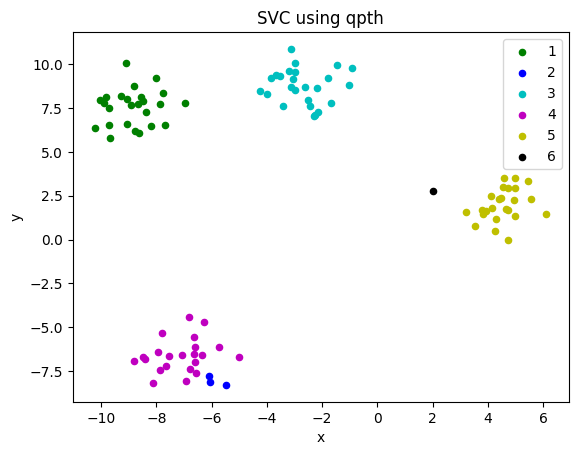

In [92]:
import torch
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import rbf_kernel
from qpth.qp import QPFunction
import matplotlib.pyplot as plt
from pandas import DataFrame
import networkx as nx

# Dataset
X_np, _ = make_blobs(n_samples=100, centers=4, random_state=42)
X = torch.tensor(X_np, dtype=torch.float32)
N = X.shape[0]
q = 1.0
p = 0.1
C = 1 / (N * p)

# Kernel
K_np = rbf_kernel(X_np, gamma=q)
K = torch.tensor(K_np, dtype=torch.float32)
Q = 0.5 * (K + K.T)  # Make symmetric
p_vec = -torch.ones(N)

# Constraints
G = torch.cat([torch.eye(N), -torch.eye(N)], dim=0)
h = torch.cat([C * torch.ones(N), torch.zeros(N)])
A = torch.ones(1, N)
b = torch.tensor([1.0])

# Solve QP
beta = QPFunction(verbose=False)(Q, p_vec, G, h, A, b)
beta_val = beta.detach().numpy()

# Support vectors
sv = (beta_val > 1e-6) & (beta_val < C)
bsv = beta_val >= C
SVs = np.where(sv)[0]
BSVs = np.where(bsv)[0]

beta_val = beta_val.ravel()  # ensure it's a 1D vector
quad_term = np.dot(beta_val, np.dot(K_np, beta_val))
R = np.mean([K_np[i, i] - 2 * np.dot(K_np[i], beta_val) + quad_term for i in SVs[:5]])


# Graph construction
adj = np.zeros((N, N), dtype=bool)
for i in range(N):
    if i in BSVs: continue
    for j in range(i + 1, N):
        if j in BSVs: continue
        connected = True
        for t in range(1, 21):
            alpha = t / 21
            x = (1 - alpha) * X_np[i] + alpha * X_np[j]
            k_x = np.exp(-q * np.sum((X_np - x) ** 2, axis=1))
            r_x = 1 - 2 * np.dot(beta_val, k_x) + quad_term
            if r_x > R:
                connected = False
                break
        if connected:
            adj[i, j] = adj[j, i] = True

# Clustering
G = nx.Graph(adj)
clusters = list(nx.connected_components(G))
labels = np.zeros(N, dtype=int)
for i, cluster in enumerate(clusters):
    for j in cluster:
        labels[j] = i + 1

# Plot
df = DataFrame(dict(x=X_np[:, 0], y=X_np[:, 1], label=labels))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots()
for key, group in df.groupby('label'):
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[int(key) % len(colors)])
plt.title("SVC using qpth")
plt.show()


In [89]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from pandas import DataFrame
import networkx as nx
from qpth.qp import QPFunction

# --- Step 1: Generate dataset ---
X_np, _ = make_blobs(n_samples=100, centers=3, random_state=42)
X = torch.tensor(X_np, dtype=torch.float32)
N = X.shape[0]
p = 0.1
C = 1 / (N * p)

# --- Step 2: Define MLP Encoder ---
class MLPEncoder(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16, output_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

encoder = MLPEncoder()

# --- Step 3: Encode points and compute kernel ---
with torch.no_grad():
    features = encoder(X)  # (N, output_dim)
K = features @ features.T
K = 0.5 * (K + K.T)  # Ensure symmetry

# --- Step 4: Set up and solve QP ---
Q = K
p_vec = -torch.ones(N)
G = torch.cat([torch.eye(N), -torch.eye(N)], dim=0)
h = torch.cat([C * torch.ones(N), torch.zeros(N)])
A = torch.ones(1, N)
b = torch.tensor([1.0])

beta = QPFunction(verbose=False)(Q, p_vec, G, h, A, b)
beta_val = beta.detach().numpy().ravel()

# --- Step 5: Identify SVs and compute radius ---
sv_mask = (beta_val > 1e-6) & (beta_val < C)
bsv_mask = beta_val >= C
SVs = np.where(sv_mask)[0]
BSVs = np.where(bsv_mask)[0]

K_np = K.detach().numpy()
quad_term = np.dot(beta_val, np.dot(K_np, beta_val))
R = np.mean([K_np[i, i] - 2 * np.dot(K_np[i], beta_val) + quad_term for i in SVs[:5]])

# --- Step 6: Build adjacency graph ---
adj = np.zeros((N, N), dtype=bool)
for i in range(N):
    if i in BSVs: continue
    for j in range(i + 1, N):
        if j in BSVs: continue
        connected = True
        for t in range(1, 21):
            alpha = t / 21
            x_interp = (1 - alpha) * X[i] + alpha * X[j]
            with torch.no_grad():
                feat_interp = encoder(x_interp.unsqueeze(0)).squeeze(0)
                k_x = (features @ feat_interp).detach().numpy()
            r_x = 1 - 2 * np.dot(beta_val, k_x) + quad_term
            if r_x > R:
                connected = False
                break
        if connected:
            adj[i, j] = adj[j, i] = True

# --- Step 7: Cluster extraction from graph ---
G_graph = nx.Graph(adj)
clusters = list(nx.connected_components(G_graph))
labels = np.zeros(N, dtype=int)
for idx, cluster in enumerate(clusters):
    for i in cluster:
        labels[i] = idx + 1

# --- Step 8: Plotting ---
df = DataFrame(dict(x=X_np[:, 0], y=X_np[:, 1], label=labels))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots()
for key, group in df.groupby('label'):
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=int(key), color=colors[int(key) % len(colors)])
plt.title("Support Vector Clustering with Deep Kernel (MLP Encoder)")
plt.show()


RuntimeError: Q is not SPD.

In [69]:
K

array([[1.        , 0.07638482, 0.03180654, ..., 0.07064968, 0.90192618,
        0.04434391],
       [0.07638482, 1.        , 0.22583311, ..., 0.96441664, 0.18321674,
        0.24444239],
       [0.03180654, 0.22583311, 1.        , ..., 0.34246758, 0.08665505,
        0.9914148 ],
       ...,
       [0.07064968, 0.96441664, 0.34246758, ..., 1.        , 0.17750265,
        0.36311422],
       [0.90192618, 0.18321674, 0.08665505, ..., 0.17750265, 1.        ,
        0.11400131],
       [0.04434391, 0.24444239, 0.9914148 , ..., 0.36311422, 0.11400131,
        1.        ]])

In [102]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.datasets import make_regression
from qpth.qp import QPFunction
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import networkx as nx
from pandas import DataFrame

# Step 1: Dataset (100 points, 2D regression)
N = 100
X_np, y_np = make_regression(n_samples=N, n_features=2, noise=10.0, random_state=42)
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32).unsqueeze(1)
labeled_idx = np.random.choice(N, 30, replace=False)
X_labeled, y_labeled = X[labeled_idx], y[labeled_idx]

# Step 2: Model: encoder + regressor
class EmbedRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 10))
        self.regressor = nn.Linear(10, 1)

    def forward(self, x):
        z = self.encoder(x)
        y_hat = self.regressor(z)
        return z, y_hat

# Step 3: Differentiable RBF kernel in PyTorch
def rbf_kernel_torch(z, gamma=1.0):
    return z @ z.t()

    z_norm2 = (z ** 2).sum(dim=1, keepdim=True)  # (N, 1)
    dist2 = z_norm2 + z_norm2.t() - 2 * (z @ z.t())  # (N, N)
    return torch.exp(-gamma * dist2)

# Step 4: Training loop (regression + SVC dual loss)
model = EmbedRegressor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mse_loss = nn.MSELoss()
lambda_svc = 0.01

for epoch in range(300):
    model.train()
    z_all, _ = model(X)
    K = rbf_kernel_torch(z_all, gamma=1.0)
    Q = 0.5 * (K + K.T) + 1e-3 * torch.eye(N)

    p_vec = -torch.ones(N)
    G = torch.cat([torch.eye(N), -torch.eye(N)], dim=0)
    h = torch.cat([torch.ones(N), torch.zeros(N)])
    A = torch.ones(1, N)
    b = torch.tensor([1.0])

    beta = QPFunction(verbose=False)(Q, p_vec, G, h, A, b)
    svc_loss = 0.5 * (beta @ K @ beta.t()).squeeze() - torch.sum(beta)

    _, y_hat_labeled = model(X_labeled)
    reg_loss = mse_loss(y_hat_labeled, y_labeled)
    total_loss = reg_loss + lambda_svc * svc_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

# Step 5: Solve SVC again after training (for visualization)
model.eval()
with torch.no_grad():
    z_all, _ = model(X)
z_np = z_all.numpy()

def rbf_kernel_np(z, gamma=1.0):
    z_norm2 = np.sum(z ** 2, axis=1, keepdims=True)
    dist2 = z_norm2 + z_norm2.T - 2 * z @ z.T
    return np.exp(-gamma * dist2)

K_np = rbf_kernel_np(z_np, gamma=1.0)
Q = 0.5 * (K_np + K_np.T) + 1e-3 * np.eye(N)
p = -np.ones(N)
G = np.vstack([np.eye(N), -np.eye(N)])
h = np.concatenate([np.ones(N), np.zeros(N)])
A = np.ones((1, N))
b = np.array([1.0])

Q_t = torch.tensor(Q, dtype=torch.float32)
p_t = torch.tensor(p, dtype=torch.float32)
G_t = torch.tensor(G, dtype=torch.float32)
h_t = torch.tensor(h, dtype=torch.float32)
A_t = torch.tensor(A, dtype=torch.float32)
b_t = torch.tensor(b, dtype=torch.float32)
beta_val = QPFunction(verbose=False)(Q_t, p_t, G_t, h_t, A_t, b_t).detach().numpy().ravel()

# Step 6: Clustering via adjacency in kernel space
C = 10.0
sv = (beta_val > 1e-6) & (beta_val < C)
bsv = beta_val >= C
SVs = np.where(sv)[0]
BSVs = np.where(bsv)[0]
quad_term = beta_val @ K_np @ beta_val
R = np.mean([K_np[i, i] - 2 * np.dot(K_np[i], beta_val) + quad_term for i in SVs[:5]])

adj = np.zeros((N, N), dtype=bool)
for i in range(N):
    if i in BSVs: continue
    for j in range(i + 1, N):
        if j in BSVs: continue
        connected = True
        for t in range(1, 11):
            alpha = t / 11
            x = (1 - alpha) * z_np[i] + alpha * z_np[j]
            k_x = np.exp(-np.sum((z_np - x) ** 2, axis=1))
            r_x = 1 - 2 * np.dot(beta_val, k_x) + quad_term
            if r_x > R:
                connected = False
                break
        if connected:
            adj[i, j] = adj[j, i] = True

# Step 7: Extract clusters and visualize
G_graph = nx.Graph(adj)
clusters = list(nx.connected_components(G_graph))
labels = np.zeros(N)
for i, cluster in enumerate(clusters):
    for idx in cluster:
        labels[idx] = i + 1

pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_np)
df = DataFrame(dict(x=z_pca[:, 0], y=z_pca[:, 1], label=labels))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots()
for key, group in df.groupby('label'):
    group.plot(kind='scatter', x='x', y='y', label=key, ax=ax, color=colors[int(key) % len(colors)])
plt.title("Clusters from SVC in Learned Embedding Space")
plt.show()


RuntimeError: Q is not SPD.

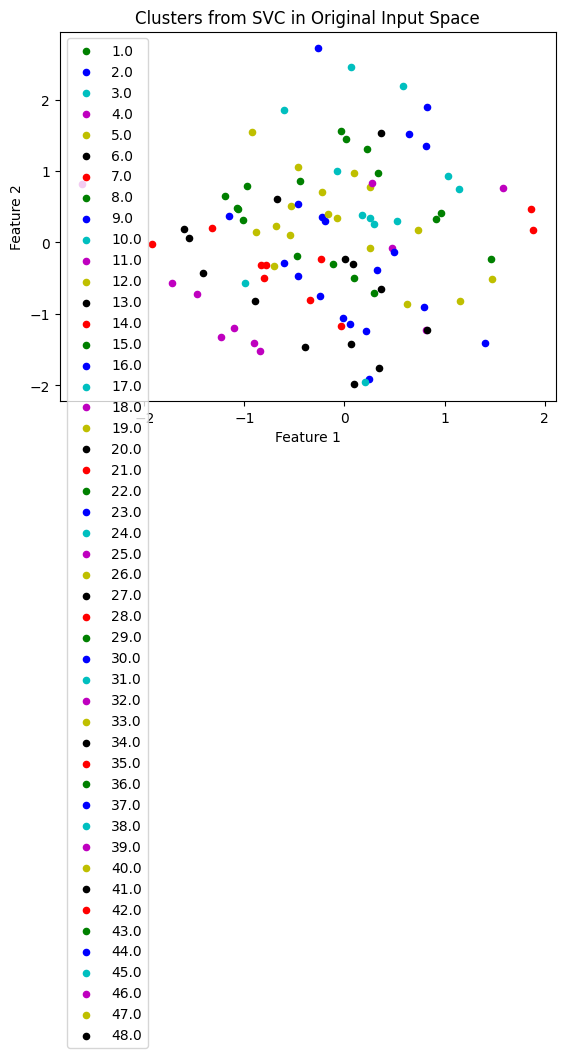

In [101]:
# Step 8: Visualize clusters in the original input space
df_orig = DataFrame(dict(x=X_np[:, 0], y=X_np[:, 1], label=labels))
fig, ax = plt.subplots()
for key, group in df_orig.groupby('label'):
    group.plot(kind='scatter', x='x', y='y', label=key, ax=ax, color=colors[int(key) % len(colors)])
plt.title("Clusters from SVC in Original Input Space")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
